> This notebook is part of the [Graph Neural Network Course](https://github.com/mlabonne/Graph-Neural-Network-Course) by [@maximelabonne](https://twitter.com/maximelabonne).

In [4]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Graph data

In [5]:
from torch_geometric.datasets import KarateClub

# Import dataset from PyTorch Geometric
dataset = KarateClub()

# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4


- This dataset only has 1 graph
- Each node has a feature vector of 34 dimensions
- We have 4 classes

In [6]:
# Print first element
print(f'Graph: {dataset[0]}')

Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


- `x=[34, 34]` is the node feature matrix with shape (number of nodes, number of features). In our case, it means that we have 34 nodes (our 34 members), each node being associated to a 34-dim feature vector.

- `edge_index=[2, 156]` represents the graph connectivity (how the nodes are connected) with shape (2, number of directed edges).

- `y=[34]` is the node ground-truth labels. In this problem, every node is assigned to one class (group), so we have one value for each node.

- `train_mask=[34]` is an optional attribute that tells which nodes should be used for training with a list of True or False statements.

In [7]:
data = dataset[0]

print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


- The node feature matrix `x` is an identity matrix: it doesn't contain any relevant information about the nodes. It could contain information like age, skill level, etc. but this is not the case in this dataset.

- It means we'll have to classify our nodes just by looking at their connections.

In [8]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

- `edge_index` is a data structure, where the graph's connections are stored in two lists (156 directed edges, which equate to 78 bidirectional edges). So, one list stores the source nodes, while the second one identifies the destination nodes.

- This method is known as a coordinate list (COO) format.

- Another way to represent graph connectivity is through an adjacency matrix

In [9]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [10]:
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


Our node ground-truth labels stored in `y` simply encode the group number (0, 1, 2, 3) for each node, which is why we have 34 values.

In [11]:
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

train_mask = torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


The train mask shows which nodes are supposed to be used for training with `True` statements. These nodes represent the training set, while the others can be considered as the test set.

In [12]:
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


- `is_directed()` tells you if the graph is directed. A directed graph signifies that the adjacency matrix is not symmetric.

- `isolated_nodes()` checks if some nodes are not connected to the rest of the graph.

- `has_self_loops()` indicates if at least one node is connected to itself.

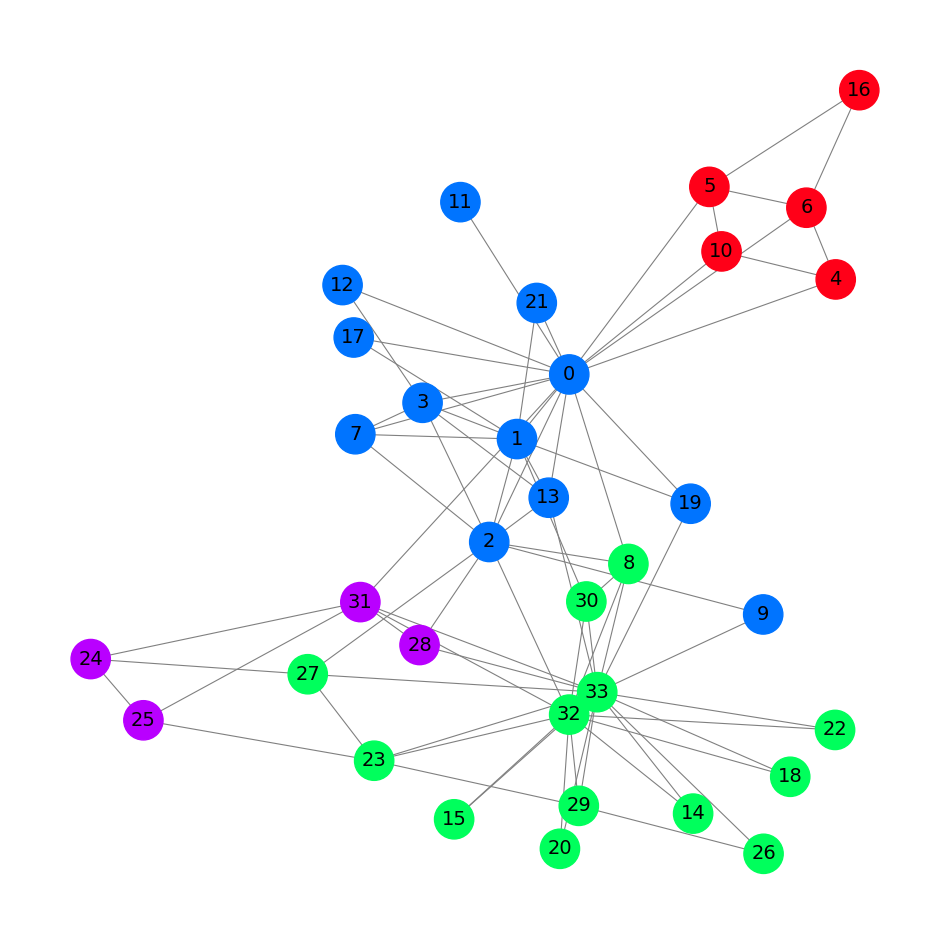

In [13]:
from torch_geometric.utils import to_networkx

# Convert a graph form PyG to NetworkX (useful for visualization)
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

## Implementing a GCN

In [14]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.48 | Acc: 14.71%
Epoch  10 | Loss: 1.29 | Acc: 38.24%
Epoch  20 | Loss: 1.08 | Acc: 64.71%
Epoch  30 | Loss: 0.92 | Acc: 67.65%
Epoch  40 | Loss: 0.77 | Acc: 73.53%
Epoch  50 | Loss: 0.62 | Acc: 73.53%
Epoch  60 | Loss: 0.49 | Acc: 73.53%
Epoch  70 | Loss: 0.40 | Acc: 88.24%
Epoch  80 | Loss: 0.34 | Acc: 91.18%
Epoch  90 | Loss: 0.30 | Acc: 91.18%
Epoch 100 | Loss: 0.27 | Acc: 91.18%
Epoch 110 | Loss: 0.25 | Acc: 91.18%
Epoch 120 | Loss: 0.24 | Acc: 91.18%
Epoch 130 | Loss: 0.23 | Acc: 91.18%
Epoch 140 | Loss: 0.22 | Acc: 91.18%
Epoch 150 | Loss: 0.22 | Acc: 91.18%
Epoch 160 | Loss: 0.21 | Acc: 91.18%
Epoch 170 | Loss: 0.20 | Acc: 91.18%
Epoch 180 | Loss: 0.20 | Acc: 91.18%
Epoch 190 | Loss: 0.19 | Acc: 94.12%
Epoch 200 | Loss: 0.16 | Acc: 97.06%


In [16]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())

In [17]:
display(html)

In [18]:
# Print embeddings
print(f'Final embeddings = {h.shape}')
print(h)

Final embeddings = torch.Size([34, 3])
tensor([[0.0000e+00, 2.2929e+00, 9.5745e-01],
        [0.0000e+00, 2.9855e+00, 1.6966e+00],
        [0.0000e+00, 2.3378e+00, 1.4925e+00],
        [0.0000e+00, 2.9013e+00, 1.3492e+00],
        [0.0000e+00, 0.0000e+00, 1.9057e-02],
        [0.0000e+00, 0.0000e+00, 2.6471e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 2.3207e+00, 1.1633e+00],
        [0.0000e+00, 4.1542e-01, 2.0928e+00],
        [0.0000e+00, 2.0053e+00, 1.3028e+00],
        [0.0000e+00, 0.0000e+00, 1.0459e-03],
        [0.0000e+00, 2.1779e+00, 1.2386e+00],
        [0.0000e+00, 2.3176e+00, 1.2258e+00],
        [0.0000e+00, 2.0701e+00, 1.2633e+00],
        [0.0000e+00, 1.9813e-01, 2.2232e+00],
        [0.0000e+00, 1.7551e-01, 2.0928e+00],
        [0.0000e+00, 0.0000e+00, 1.0392e-02],
        [0.0000e+00, 2.3165e+00, 1.2495e+00],
        [0.0000e+00, 1.8005e-01, 2.0533e+00],
        [0.0000e+00, 1.9843e+00, 1.3230e+00],
        [0.0000e+00, 1.5804e-01, 2.1077e+

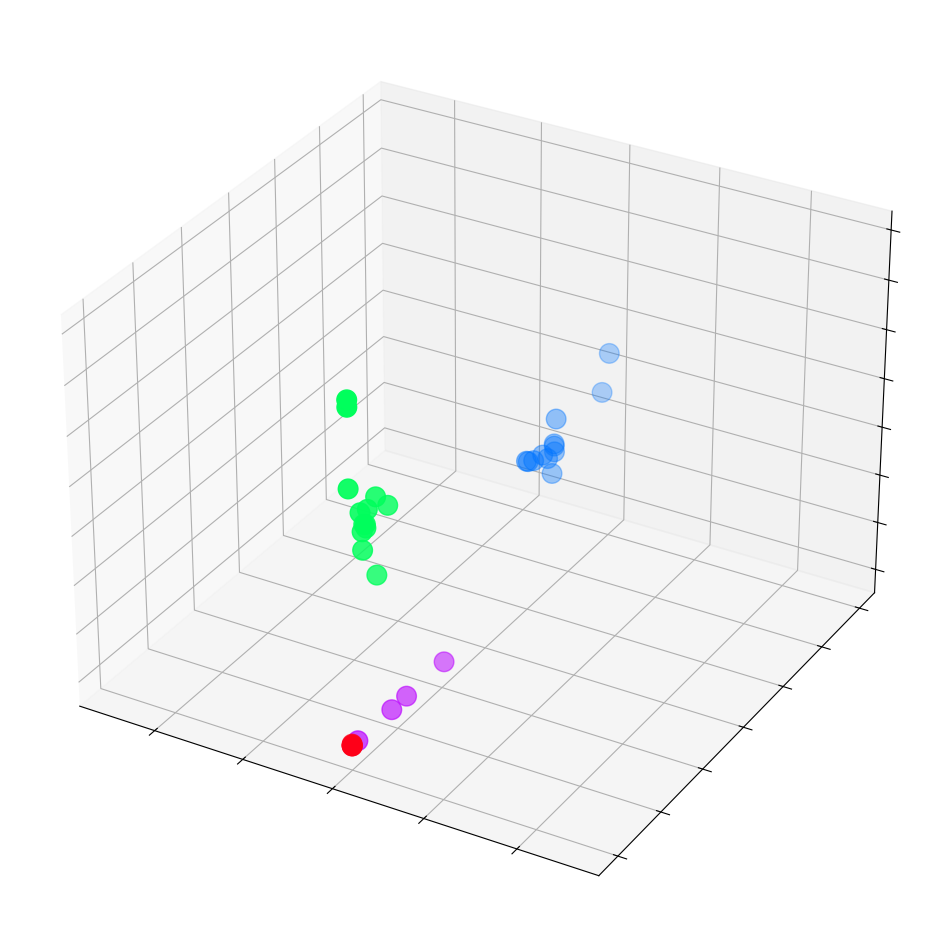

In [19]:
# Get first embedding at epoch = 0
embed = h.detach().cpu().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

plt.show()

In [20]:
%%capture

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [21]:
display(html)